In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Statistical modeling
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from scipy.stats import chi2

# Machine Learning - preprocessing and model selection
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

# Machine Learning - models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Machine Learning - metrics
from sklearn.metrics import accuracy_score, recall_score, f1_score, RocCurveDisplay
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.metrics import geometric_mean_score 
from sklearn.model_selection import cross_val_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
from numpy.random import seed

# Tree Search 
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline  

# SHAP Values
import shap  
from sklearn_evaluation.plot import grid_search  

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Introduction/Overview
This is a red and white wine quality dataset with physiochemical predictors and a multiclass target variable that is the result of wine tasters rating the wine on scale of 0-10. Preliminary investiation into modeling the multiclass classification tasks proved to not have a well modeled result using logisitic regression. To overcome this we changed the multiclass target to a binary good/bad based on a score of greater than 5, or less than or equal to 5. This presented more robust analysis using logistic and tree methods. This notebook attempted to compare the modeling in a few ways. First it uses the full wine dataset which combines the red and white datasets together and adds a column for the red/white categorical variable.

With the Full(combined) dataset we first model with classical logregression statistics to obtain the coefficients and p-values for each predictor variable. We then make a reduced model based on variables with significant p-values as long as it does not change the overall fit of the model. The Goodness of fit is then evaluated with the Chi-squares test.

We then perform Machine Learning Logistic Regression and a GridSearch added TreeSearch of decisiontree and RandomForest. These ML models are evaluated by their Accuracy, F1, and G-mean scores through their confusion matrices. Furthermore the final tree model can be evaluated for Feature importance by both Random Forest and SHAP

These above modeling paradigms are then followed for the separate Red and White datasets to see if there is a siginificant enough difference in the data that would make the Combined Dataset modeling unfit.

## Data Prep/Wrangling

In [2]:
#load red wine dataset
red_wine_df = pd.read_csv('RedWineQuality.csv')
#load white wine dataset
white_wine_df = pd.read_csv('WhiteWineQuality.csv')
#Add new column to specify wine type
red_wine_df['wine_type'] = 'Red'
white_wine_df['wine_type'] = 'White'
#combine the two dataframe
combined_df = pd.concat([red_wine_df,white_wine_df], ignore_index = True) #reset index after concatenation
print (combined_df)
# 6500 Data points combined
# 4900 White Wine
# 1600 Red Wine

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.4              0.70         0.00             1.9      0.076   
1               7.8              0.88         0.00             2.6      0.098   
2               7.8              0.76         0.04             2.3      0.092   
3              11.2              0.28         0.56             1.9      0.075   
4               7.4              0.70         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
6492            6.2              0.21         0.29             1.6      0.039   
6493            6.6              0.32         0.36             8.0      0.047   
6494            6.5              0.24         0.19             1.2      0.041   
6495            5.5              0.29         0.30             1.1      0.022   
6496            6.0              0.21         0.38             0.8      0.020   

      free sulfur dioxide  

In [3]:
combined_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,Red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,Red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,Red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,Red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,Red


In [4]:
combined_df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'wine_type'],
      dtype='object')

In [5]:
# Remove white spaces in already defined variable names
combined_df = combined_df.rename(columns=lambda x: x.strip().replace(' ', '_'))
# Check the column names again
print(combined_df.columns)

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'wine_type'],
      dtype='object')


In [6]:
combined_df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,Red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,Red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,Red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,Red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,Red


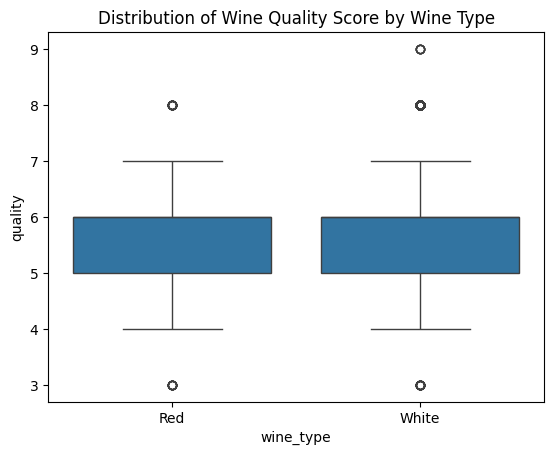

In [7]:
#distribution of the target variable (wine quality score) across red and white wines
sns.boxplot(x = 'wine_type', y = 'quality', data = combined_df)
plt.title('Distribution of Wine Quality Score by Wine Type')
plt.show()

In [8]:
combined_df['binary_quality'] = combined_df['quality'].apply(lambda x: 'bad' if x <= 5 else 'good')
print(combined_df['binary_quality'])

0        bad
1        bad
2        bad
3       good
4        bad
        ... 
6492    good
6493     bad
6494    good
6495    good
6496    good
Name: binary_quality, Length: 6497, dtype: object


In [9]:
combined_df.head(10)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,wine_type,binary_quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,Red,bad
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,Red,bad
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,Red,bad
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,Red,good
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,Red,bad
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5,Red,bad
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5,Red,bad
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7,Red,good
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7,Red,good
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5,Red,bad


In [10]:
# Convert 'binary quality' column to 0 and 1
combined_df['binary_quality'] = combined_df['binary_quality'].map({'bad': 0, 'good': 1})

In [11]:
# Verify the conversion
print(combined_df['binary_quality'].unique())

[0 1]


In [12]:
# Count of classes
combined_df.binary_quality.value_counts()

binary_quality
1    4113
0    2384
Name: count, dtype: int64

<Axes: ylabel='binary_quality'>

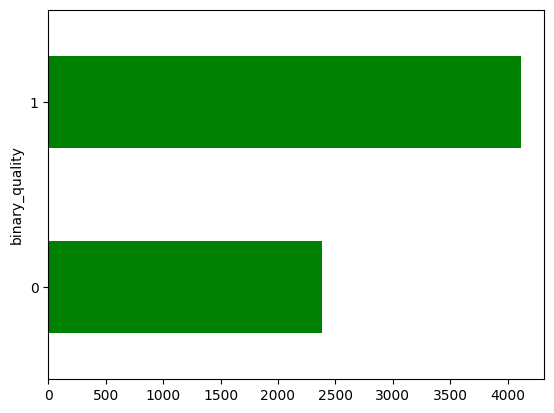

In [13]:
# Plot the distribution of the classes
combined_df.binary_quality.value_counts().sort_values().plot(kind = 'barh',color='green')

In [14]:
continuous_features = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
                       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
                       'pH', 'sulphates', 'alcohol']

target_variable = 'binary_quality'

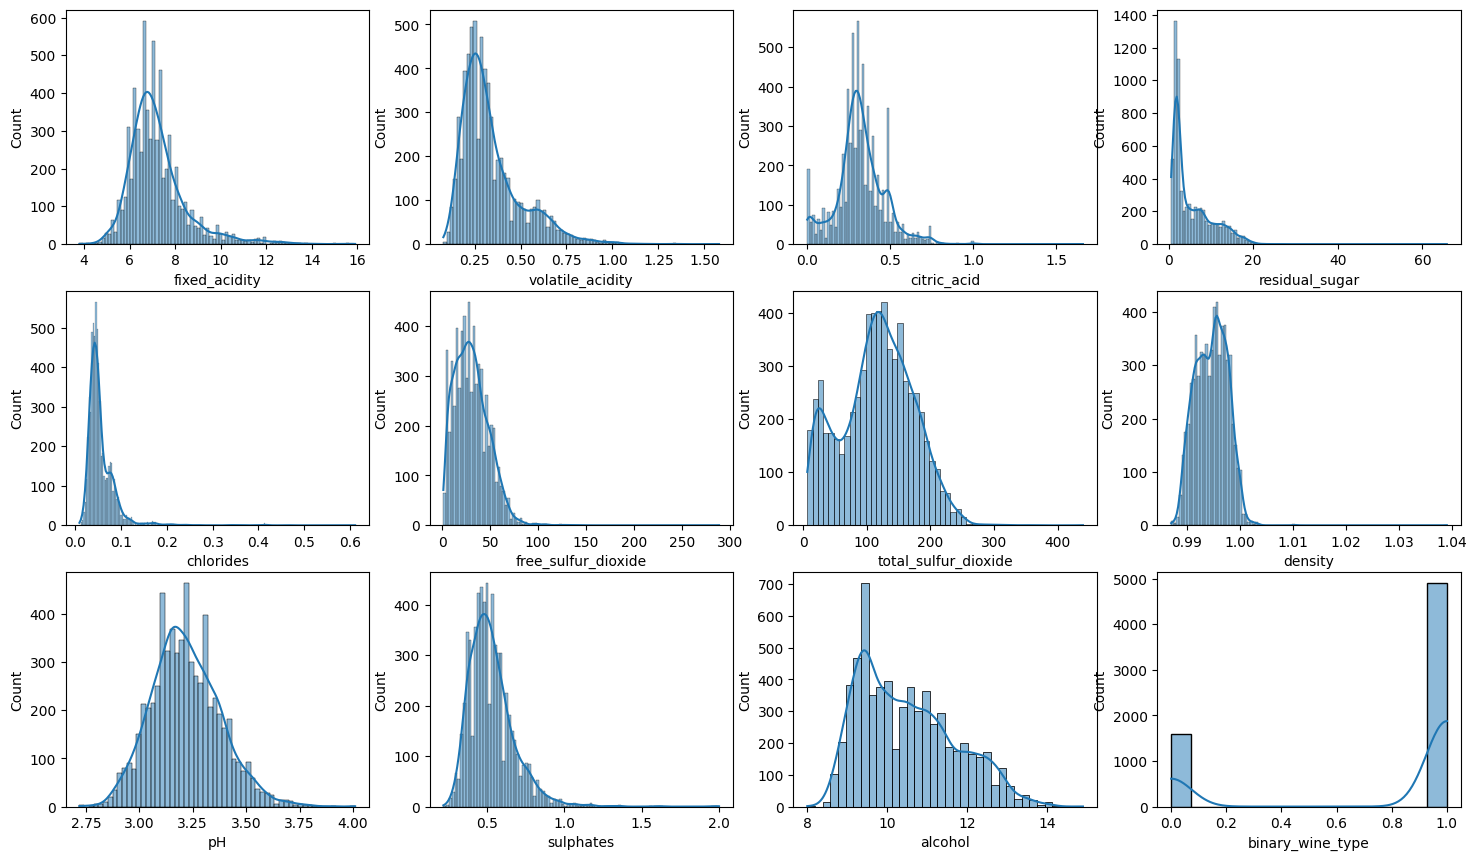

In [102]:
# Visualize the univariate distribution of each continuous feature
plt.figure(figsize=(18, 14))
for i, feature in enumerate(continuous_features, 1):
    plt.subplot(4, 4, i)
    sns.histplot(combined_df[feature], kde=True)
    #plt.title(feature)
plt.show()

In [16]:
combined_df.columns

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'wine_type', 'binary_quality'],
      dtype='object')

## Plot pairwise relationships in a dataset

Exploratory pairwise plot to get an idea of what the data looks like

In [17]:
#sns.pairplot(combined_df[['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       #'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       #'pH', 'sulphates', 'alcohol', 'wine_type', 'binary_quality']], hue='binary_quality')

In [18]:
# Convert 'wine_type' column to 0 and 1
#Red = 0
#White = 1
combined_df['binary_wine_type'] = combined_df['wine_type'].map({'Red': 0, 'White': 1})

In [19]:
# Verify the conversion
print(combined_df['binary_wine_type'].unique())

[0 1]


In [20]:
# Count of classes
combined_df.binary_wine_type.value_counts()

binary_wine_type
1    4898
0    1599
Name: count, dtype: int64

In [21]:
combined_df.tail()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,wine_type,binary_quality,binary_wine_type
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,White,1,1
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,White,0,1
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,White,1,1
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,White,1,1
6496,6.0,0.21,0.38,0.8,0.020,22.0,98.0,0.98941,3.26,0.32,11.8,6,White,1,1


In [22]:
combined_df.columns

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'wine_type', 'binary_quality',
       'binary_wine_type'],
      dtype='object')

## Classical Logistic Regression Model using GLM package
Here we are performing the classical statistical approach to creating our linear model

In [23]:
seed(7)

# Fit the logistic regression model using glm() with Binomial family
Fullmodel = smf.glm(formula="binary_quality~fixed_acidity + volatile_acidity + citric_acid + residual_sugar + chlorides + free_sulfur_dioxide +total_sulfur_dioxide + density + pH + sulphates +alcohol + C(binary_wine_type)",
                    data=combined_df, family=sm.families.Binomial())
Fullresult = Fullmodel.fit()
# Print the summary of the model
print(Fullresult.summary())
print("AIC:", Fullresult.aic)

                 Generalized Linear Model Regression Results                  
Dep. Variable:         binary_quality   No. Observations:                 6497
Model:                            GLM   Df Residuals:                     6484
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3347.0
Date:                Fri, 19 Apr 2024   Deviance:                       6693.9
Time:                        21:48:54   Pearson chi2:                 6.80e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2475
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

# chlorides, fixed_acidity, and citric_acid has a larger p value. We will remove this to see what that does to the AIC. 

# Reduced Pairplot of only selected predictors

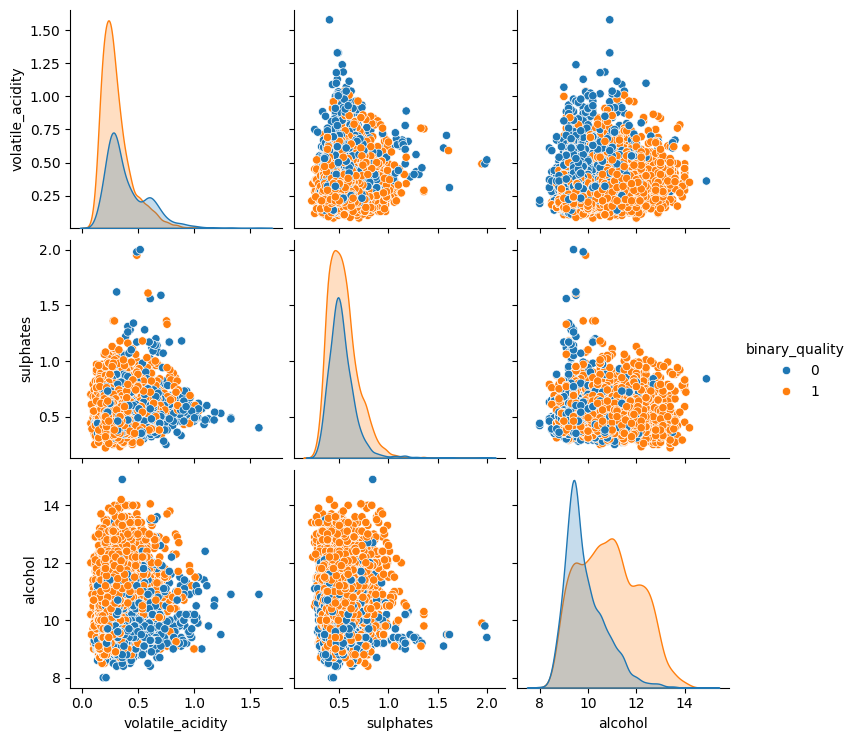

In [24]:
sns.pairplot(combined_df[['volatile_acidity', 'sulphates', 'alcohol', 'wine_type', 'binary_quality']], hue='binary_quality')

In [25]:
seed(7)

# Fit the logistic regression model using glm() with Binomial family
Nestedmodel = smf.glm(formula="binary_quality~ volatile_acidity + residual_sugar + free_sulfur_dioxide + total_sulfur_dioxide + density + pH + sulphates + alcohol + C(binary_wine_type)",
                    data=combined_df, family=sm.families.Binomial())
Nestedresult = Nestedmodel.fit()
# Print the summary of the model
print(Nestedresult.summary())
print("AIC:", Nestedresult.aic)

                 Generalized Linear Model Regression Results                  
Dep. Variable:         binary_quality   No. Observations:                 6497
Model:                            GLM   Df Residuals:                     6487
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3352.1
Date:                Fri, 19 Apr 2024   Deviance:                       6704.1
Time:                        21:48:56   Pearson chi2:                 6.76e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2463
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

The comparison of two logistic regression models suggests full model AIC (6719) is not much different from reduced model (6724)

# Statistical Inference for Logistic Regression

In [26]:
# 'FullResult' is the fitted GLM model from statsmodels
residual_deviance = Fullresult.deviance
degrees_of_freedom_residual = Fullresult.df_resid

# Calculate the p-value
p_value = 1 - chi2.cdf(residual_deviance, degrees_of_freedom_residual)

print(f"Goodness-of-fit test p-value: {p_value}")

Goodness-of-fit test p-value: 0.03363984960914035


The Chi-square test for the Residual deviance gives a p-value smaller than 0.05, which indicates that the Full model is not good for fitting both datasets combined.

In [27]:
# 'Nestedresult' is the fitted GLM model from statsmodels
residual_deviance = Nestedresult.deviance
degrees_of_freedom_residual = Nestedresult.df_resid

# Calculate the p-value
p_value = 1 - chi2.cdf(residual_deviance, degrees_of_freedom_residual)

print(f"Goodness-of-fit test p-value: {p_value}")

Goodness-of-fit test p-value: 0.0292967286206941


The Chi-square test for the Residual deviance of the reduced model gives a p-value smaller than 0.05, which indicates that the model is not good for fitting both datasets combined. This is the same as the Full Model

## Odds Ratio (exp(beta))

In [28]:
# Computing odds ratios (OR)
odds_ratios = np.exp(Nestedresult.params)

# Computing 95% confidence intervals for the odds ratios
conf_int = Nestedresult.conf_int()
conf_int_odds_ratios = np.exp(conf_int)

# Visualizing results
import pandas as pd
odds_ratios_df = pd.DataFrame({
    'Odds Ratio': odds_ratios,
    '95% CI Lower': conf_int_odds_ratios[0],
    '95% CI Upper': conf_int_odds_ratios[1]
})

print(odds_ratios_df)

                            Odds Ratio  95% CI Lower  95% CI Upper
Intercept                 6.717167e+32  2.188855e+08  2.061367e+57
C(binary_wine_type)[T.1]  5.438239e-01  3.779122e-01  7.825743e-01
volatile_acidity          8.628462e-03  5.030020e-03  1.480121e-02
residual_sugar            1.104636e+00  1.076368e+00  1.133646e+00
free_sulfur_dioxide       1.014585e+00  1.009511e+00  1.019684e+00
total_sulfur_dioxide      9.941005e-01  9.920582e-01  9.961470e-01
density                   8.430571e-38  3.306194e-62  2.149738e-13
pH                        1.711815e+00  1.145878e+00  2.557262e+00
sulphates                 6.083631e+00  3.685148e+00  1.004317e+01
alcohol                   2.394429e+00  2.187228e+00  2.621258e+00


Interpretation of Odds Ratio
Fixed_acidity:
Volatile_acidity:
Citric_acid:
Residual_sugar:
Free_sulfur_dioxide:
Total_sulfur_dioxide:
Density:
pH:
Sulphates:
Alcohol:
Binary_wine_type:

# Combined Wine Dataset Logistic Regression Machine Learning Approach

In [29]:
# Define feature names

continuous_features = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
                       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
                       'pH', 'sulphates', 'alcohol','binary_wine_type']



In [30]:
seed(7)

# Splitting the dataset into features and target variable
X = combined_df.drop(['wine_type','binary_wine_type','quality','binary_quality'], axis=1)
y = combined_df['binary_quality']

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7, stratify=y)

In [31]:
# Defining preprocessing for numerical and categorical columns
numeric_features = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
                    'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
                    'pH', 'sulphates', 'alcohol'] 

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

# Creating the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
    ])

# Creating the pipeline
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Setting up the parameter grid for hyperparameter tuning
param_grid = {
    'classifier__C': np.logspace(-4, 4, 20),
    'classifier__solver': ['lbfgs', 'liblinear']
}

# Setting up stratified 5-fold cross-validation
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(lr_pipeline, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

# Fitting the grid search to the training data
grid_search.fit(X_train, y_train)

# Extracting the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Evaluating the model on the test data
best_model = grid_search.best_estimator_
y_pred_test = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)

# Calculating metrics
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
error_rate_train = 1 - accuracy_train
error_rate_test = 1 - accuracy_test
f1_score_test = f1_score(y_test, y_pred_test)
gmean_score_test = geometric_mean_score(y_test, y_pred_test)

# Confusion Matrix for Test Data
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Print metrics
print(f"Train Accuracy: {accuracy_train*100:.2f}%")
print(f"Test Accuracy: {accuracy_test*100:.2f}%")
print(f"Train Error Rate: {error_rate_train*100:.2f}%")
print(f"Test Error Rate: {error_rate_test*100:.2f}%")
print(f"Test F1 Score: {f1_score_test:.2f}")
print(f"Test Geometric Mean Score: {gmean_score_test:.2f}")

# Detailed classification report
print("\nClassification Report for Logistic Regression:")
print(classification_report(y_test, y_pred_test))
print(best_params)
print(conf_matrix)


Train Accuracy: 74.31%
Test Accuracy: 72.92%
Train Error Rate: 25.69%
Test Error Rate: 27.08%
Test F1 Score: 0.80
Test Geometric Mean Score: 0.67

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.66      0.53      0.59       477
           1       0.76      0.84      0.80       823

    accuracy                           0.73      1300
   macro avg       0.71      0.69      0.69      1300
weighted avg       0.72      0.73      0.72      1300

{'classifier__C': 11.288378916846883, 'classifier__solver': 'liblinear'}
[[253 224]
 [128 695]]


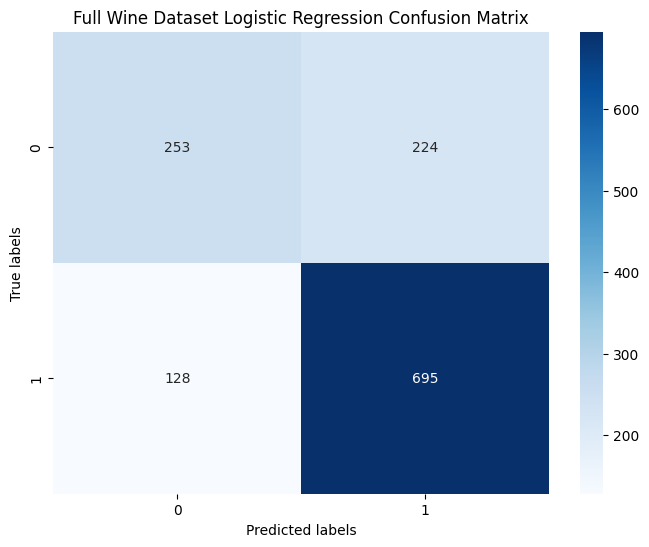

In [104]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Full Wine Dataset Logistic Regression Confusion Matrix')
plt.show()

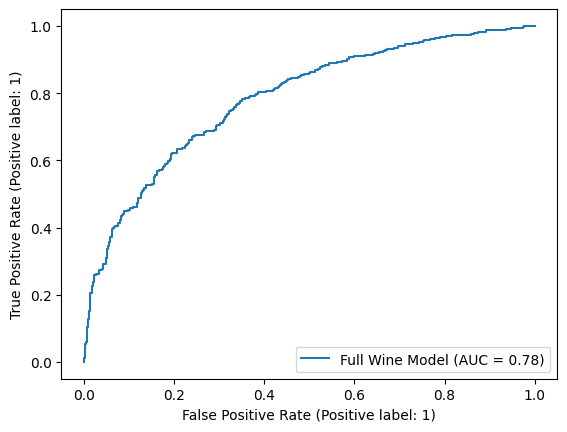

In [33]:
RocCurveDisplay.from_estimator(best_model , X_test, y_test, name='Full Wine Model')

### ML Log Summary
The Full Wine Data set has Test Accuracy of 73%, F1 of 0.8, and Gmean of 0.67 indicating that it is a relatively good model.  
The confusion matrix also indicates not the best prediction of the test set into the correct labels.
The AUC for the ROC curve is 0.78.

### Full Wine Dataset Tree Search

In [34]:
tree_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('oversample', SMOTE(random_state=7)),
    ('undersample', RandomUnderSampler(random_state=7)),
    ('classifier', DecisionTreeClassifier(random_state=7)),
])

In [35]:
tree_param_grid = [
    {
        'classifier': [DecisionTreeClassifier(random_state=7)],
        'classifier__max_depth': [2,3,4,5]
    },
    {
        'classifier': [RandomForestClassifier(random_state=7)],
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [3, 10, 20]
    }
]

In [36]:
tree_grid_search_full = GridSearchCV(tree_pipeline, tree_param_grid, cv=cv, scoring='f1')  

tree_grid_search_full.fit(X_train, y_train)

tree_best_params_full = tree_grid_search_full.best_params_
tree_best_score_full = tree_grid_search_full.best_score_

tree_best_model_full = tree_grid_search_full.best_estimator_
tree_y_pred_test_full = tree_best_model_full.predict(X_test)
tree_y_pred_train_full = tree_best_model_full.predict(X_train)

tree_accuracy_train_full = accuracy_score(y_train, tree_y_pred_train_full)
tree_accuracy_test_full = accuracy_score(y_test, tree_y_pred_test_full)
tree_error_rate_train_full = 1 - tree_accuracy_train_full
tree_error_rate_test_full = 1 - tree_accuracy_test_full
tree_f1_score_test_full = f1_score(y_test, tree_y_pred_test_full)  



tree_conf_matrix_full = confusion_matrix(y_test, tree_y_pred_test_full)
print(tree_conf_matrix_full )

print(f"Train Accuracy: {tree_accuracy_train_full*100:.2f}%")
print(f"Test Accuracy: {tree_accuracy_test_full*100:.2f}%")
print(f"Train Error Rate: {tree_error_rate_train_full*100:.2f}%")
print(f"Test Error Rate: {tree_error_rate_test_full*100:.2f}%")
print(f"Test F1 Score: {tree_f1_score_test_full:.2f}")

print(classification_report(y_test, tree_y_pred_test_full))

[[369 108]
 [121 702]]
Train Accuracy: 100.00%
Test Accuracy: 82.38%
Train Error Rate: 0.00%
Test Error Rate: 17.62%
Test F1 Score: 0.86
              precision    recall  f1-score   support

           0       0.75      0.77      0.76       477
           1       0.87      0.85      0.86       823

    accuracy                           0.82      1300
   macro avg       0.81      0.81      0.81      1300
weighted avg       0.82      0.82      0.82      1300



In [37]:
print(tree_best_params_full)
print(tree_best_model_full)
tree_geo_mean_white = geometric_mean_score(y_test, tree_y_pred_test_full)
print(f"Gmean: {tree_geo_mean_white}")

{'classifier': RandomForestClassifier(max_depth=20, n_estimators=200, random_state=7), 'classifier__max_depth': 20, 'classifier__n_estimators': 200}
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['fixed_acidity',
                                                   'volatile_acidity',
                                                   'citric_acid',
                                                   'residual_sugar',
                                                   'chlorides',
                                                   'free_sulfur_dioxide',
                                                   'total_sulfur_dioxide',
                                                   'density', 'pH', 'sulphates',
                                                   'alcohol'])])),
                ('oversample', SMOTE(random_state=7)),
                ('undersample', RandomUnderSampler(ra

In [38]:
final_model_full = tree_best_model_full.named_steps['classifier']
print(final_model_full)

RandomForestClassifier(max_depth=20, n_estimators=200, random_state=7)


In [39]:
feature_importances_full = final_model_full.feature_importances_
print(feature_importances_full)

[0.06704569 0.11414884 0.07428872 0.07284972 0.08270405 0.07657729
 0.0741528  0.10420718 0.06893582 0.08067651 0.18441341]


In [40]:
feature_names_full = X.columns

mdi_importances_full = pd.Series(
    final_model_full.feature_importances_, index=feature_names_full
).sort_values(ascending=True)

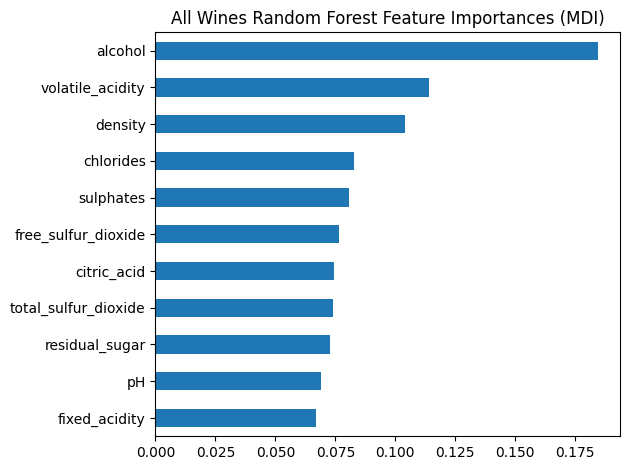

In [41]:
ax = mdi_importances_full.plot.barh()
ax.set_title("All Wines Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()

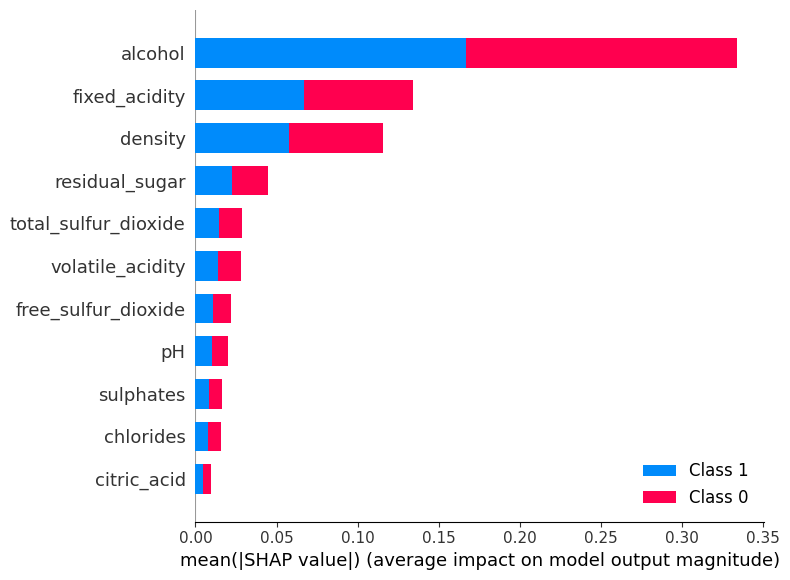

In [42]:
explainer_full = shap.TreeExplainer(final_model_full)
shap_values_full = explainer_full.shap_values(X_test)
shap.summary_plot(shap_values_full, X_test)

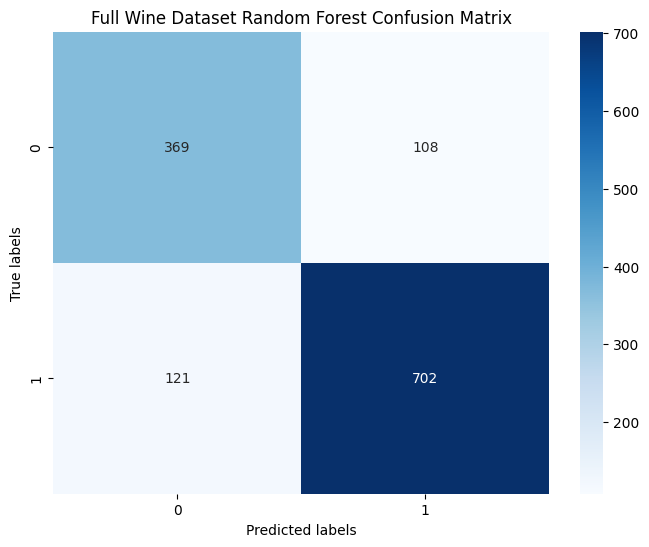

In [105]:
plt.figure(figsize=(8, 6))
sns.heatmap(tree_conf_matrix_full, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Full Wine Dataset Random Forest Confusion Matrix')
plt.show()

### Full Dataset Tree Summary
The Tree search led to much better model fitting, with an improved confusion matrix leading to a Test Accuracy of 82% and Gmean of 0.81 verus only 0.67 for the Log Regression. 
The Feature Importance listed Alcohol and Volatile Acidity as top 2, while SHAP had Alcohol and Fixed Acidity as top 2.

# Wine Datasets Modeled Separately Classical and Machine Learning

### Data Wrangling

In [44]:
red_df = pd.read_csv('winequality-red.csv',delimiter=';')
white_df = pd.read_csv('winequality-white.csv', delimiter=';')
red_df.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [45]:
white_df.tail()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7
4897,6.0,0.21,0.38,0.8,0.020,22.0,98.0,0.98941,3.26,0.32,11.8,6


In [46]:
class_map = {3:'bad',4:'bad',5:'bad', 6:'good',7:'good',8:'good',9:'good'}
red_df_cat = red_df
red_df_cat['quality_cat'] = red_df['quality'].map(class_map)
red_df2_cat = red_df_cat.rename(columns={'fixed acidity':'fixed_acidity', 'volatile acidity':'volatile_acidity','citric acid':'citric_acid','residual sugar':'residual_sugar','free sulfur dioxide':'free_sulfur_dioxide','total sulfur dioxide':'total_sulfur_dioxide','wine type':'wine_type'})
red_df2_cat['quality_num'] = red_df2_cat['quality_cat'].map({'bad':0, 'good':1})
red_df2_cat.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,quality_cat,quality_num
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,bad,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,bad,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,bad,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,good,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,bad,0


In [47]:
white_df_cat = white_df
white_df_cat['quality_cat'] = white_df['quality'].map(class_map)
white_df2_cat = white_df_cat.rename(columns={'fixed acidity':'fixed_acidity', 'volatile acidity':'volatile_acidity','citric acid':'citric_acid','residual sugar':'residual_sugar','free sulfur dioxide':'free_sulfur_dioxide','total sulfur dioxide':'total_sulfur_dioxide','wine type':'wine_type'})
white_df2_cat['quality_num'] = white_df2_cat['quality_cat'].map({'bad':0, 'good':1})
white_df2_cat.head()



,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,quality_cat,quality_num
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,good,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,good,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,good,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,good,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,good,1


In [48]:
import seaborn as sns
#sns.pairplot(red_df2_cat, hue ='quality_cat', hue_order=['bad','good'])


In [49]:
#sns.pairplot(white_df2_cat, hue ='quality_cat',hue_order=['bad','good'])

Still a lot of overlap with the predictors on both classes, but can see some separation of certain variables (alcohol, citric acid, volatile acidity)

In [50]:
# Red Wine Classical Logistic Regression
# Trying with Categorical Target Variable as Strings (bad/good)
red_full_model = smf.glm(formula= 'quality_num~fixed_acidity+volatile_acidity+citric_acid+residual_sugar+chlorides+free_sulfur_dioxide+total_sulfur_dioxide+density+pH+sulphates+alcohol', data = red_df2_cat,
                family =sm.families.Binomial())
red_full_result = red_full_model.fit()

print(red_full_result.summary())
print('AIC', red_full_result.aic)

                 Generalized Linear Model Regression Results                  
Dep. Variable:            quality_num   No. Observations:                 1599
Model:                            GLM   Df Residuals:                     1587
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -827.81
Date:                Fri, 19 Apr 2024   Deviance:                       1655.6
Time:                        21:50:00   Pearson chi2:                 1.87e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2925
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               42.9499 

In [51]:
# Red Wine Model Chi-Square
residual_deviance = red_full_result.deviance
degrees_of_freedom_residual = red_full_result.df_resid

# Calculate the p-value
p_value = 1 - chi2.cdf(residual_deviance, degrees_of_freedom_residual)

print(f"Goodness-of-fit test p-value: {p_value}")

Goodness-of-fit test p-value: 0.112612095506326


### Remove Denity, pH, Residual Sugar, Fixed_acidity from Full Model (Highest P-values

In [52]:
# Reduced Red Wine Model 
red_reduced_model = smf.glm(formula= 'quality_num~volatile_acidity+citric_acid+chlorides+free_sulfur_dioxide+total_sulfur_dioxide+sulphates+alcohol', data = red_df2_cat,
                family =sm.families.Binomial())
red_reduced_result = red_reduced_model.fit()

print(red_reduced_result.summary())
print('AIC', red_reduced_result.aic)

                 Generalized Linear Model Regression Results                  
Dep. Variable:            quality_num   No. Observations:                 1599
Model:                            GLM   Df Residuals:                     1591
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -832.08
Date:                Fri, 19 Apr 2024   Deviance:                       1664.2
Time:                        21:50:01   Pearson chi2:                 1.66e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2887
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -8.0594 

In [53]:
# Red Wine Reduced Model Chi-Square
residual_deviance = red_reduced_result.deviance
degrees_of_freedom_residual = red_reduced_result.df_resid

# Calculate the p-value
p_value = 1 - chi2.cdf(residual_deviance, degrees_of_freedom_residual)

print(f"Goodness-of-fit test p-value: {p_value}")

Goodness-of-fit test p-value: 0.09864982842258252


### Red Wine Summary

AIC goes from 1679 (Full) to 1680(reduced) indicating a good tradeoff between fit and complexity.  
Chi Squared value goes from 0.11 (Full) to 0.10 (Reduced) so maybe the Full model is a bit better

These Chi-squared are actaully significant on a 0.05 significance level compared to the 0.03 of the full Wine Dataset

# White Wine Classical Log Reg Modeling

In [54]:
# White Wine Classical Logistic Regression
white_full_model = smf.glm(formula= 'quality_num~fixed_acidity+volatile_acidity+citric_acid+residual_sugar+chlorides+free_sulfur_dioxide+total_sulfur_dioxide+density+pH+sulphates+alcohol', data = white_df2_cat,
                family =sm.families.Binomial())
white_full_result = white_full_model.fit()

print(white_full_result.summary())
print('AIC', white_full_result.aic)

                 Generalized Linear Model Regression Results                  
Dep. Variable:            quality_num   No. Observations:                 4898
Model:                            GLM   Df Residuals:                     4886
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2466.3
Date:                Fri, 19 Apr 2024   Deviance:                       4932.6
Time:                        21:50:01   Pearson chi2:                 5.05e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2351
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              258.2369 

In [55]:
# ChiSquared Metric
residual_deviance = white_full_result.deviance
degrees_of_freedom_residual = white_full_result.df_resid

# Calculate the p-value
p_value = 1 - chi2.cdf(residual_deviance, degrees_of_freedom_residual)

print(f"Goodness-of-fit test p-value: {p_value}")

Goodness-of-fit test p-value: 0.3168213452578804


### White Wine Reduced Model Remove Fixed Acicity, Citric Acid,  Chlorides, and total_sulfur_dioxide

In [56]:
# White Wine Reduced Model Classical Logistic Regression
white_reduced_model = smf.glm(formula= 'quality_num~volatile_acidity+residual_sugar+free_sulfur_dioxide+density+pH+sulphates+alcohol', data = white_df2_cat,
                family =sm.families.Binomial())
white_reduced_result = white_reduced_model.fit()

print(white_reduced_result.summary())
print('AIC', white_full_result.aic)

                 Generalized Linear Model Regression Results                  
Dep. Variable:            quality_num   No. Observations:                 4898
Model:                            GLM   Df Residuals:                     4890
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2467.3
Date:                Fri, 19 Apr 2024   Deviance:                       4934.6
Time:                        21:50:01   Pearson chi2:                 5.01e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2348
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             239.0020    

In [57]:
# ChiSquared Metric
residual_deviance = white_reduced_result.deviance
degrees_of_freedom_residual = white_reduced_result.df_resid

# Calculate the p-value
p_value = 1 - chi2.cdf(residual_deviance, degrees_of_freedom_residual)

print(f"Goodness-of-fit test p-value: {p_value}")

Goodness-of-fit test p-value: 0.32403175086899727


# Classical Stats Separate Model Summary
### White Reduced Model has same AIC 4956 (full) vs 4956 (reduced). 
The Chi-squared changes from 0.31 (Full) to 0.32(Reduced) indicating the reduced model is actually a better fit.  

Both Red and White show that Fixed Acidity was not important, but differed on the other variables

Also much better than Full Dataset at 0.31 vs 0.03. Something really different of Red Wine versus White wine

# Machine Learning with separate Red and White Datasets

In [58]:
red_df2_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         1599 non-null   float64
 1   volatile_acidity      1599 non-null   float64
 2   citric_acid           1599 non-null   float64
 3   residual_sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free_sulfur_dioxide   1599 non-null   float64
 6   total_sulfur_dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
 12  quality_cat           1599 non-null   object 
 13  quality_num           1599 non-null   int64  
dtypes: float64(11), int64(2), object(1)
memory usage: 175.0+ KB


In [59]:
red_x = red_df2_cat.drop(['quality_cat','quality_num','quality'], axis=1)
red_y = red_df2_cat['quality_num']
red_x.head()
#print(red_y)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [60]:
red_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         1599 non-null   float64
 1   volatile_acidity      1599 non-null   float64
 2   citric_acid           1599 non-null   float64
 3   residual_sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free_sulfur_dioxide   1599 non-null   float64
 6   total_sulfur_dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
dtypes: float64(11)
memory usage: 137.5 KB


In [61]:
red_x_train, red_x_test, red_y_train, red_y_test = train_test_split(
    red_x, red_y, test_size=0.2, random_state=7, stratify=red_y)

In [62]:
red_num_variable = red_x.select_dtypes(include=['int64', 'float64']).columns
red_cat_variable = red_x.select_dtypes(include=['object', 'bool']).columns

In [63]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, red_num_variable),
        ('cat', categorical_transformer, red_cat_variable)
    ])

In [64]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=10, max_iter=1000))
])

In [65]:
param_grid = {
    'classifier__C': np.logspace(-4, 4, 20),
    'classifier__solver': ['lbfgs', 'liblinear']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy')
grid_search.fit(red_x_train, red_y_train)

# Print the best hyperparameters for logistic regression
print("Best hyperparameters for Logistic Regression:")
print(grid_search.best_params_)

Best hyperparameters for Logistic Regression:
{'classifier__C': 0.012742749857031334, 'classifier__solver': 'liblinear'}


In [66]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_


best_model = grid_search.best_estimator_
y_pred_test2 = best_model.predict(red_x_test)
y_pred_train2 = best_model.predict(red_x_train)
print(best_params)
print(best_model)

{'classifier__C': 0.012742749857031334, 'classifier__solver': 'liblinear'}
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index([], dtype='object'))])),
                ('classifier',
                 LogisticRegression(C=0.012742749857031334, max_iter=1000,
                                    random_state=10, solver='liblinear'))])


In [67]:
accuracy_train = accuracy_score(red_y_train, y_pred_train2)
accuracy_test = accuracy_score(red_y_test, y_pred_test2)
error_rate_train = 1 - accuracy_train
error_rate_test = 1 - accuracy_test
f1_score_test = f1_score(red_y_test, y_pred_test2, pos_label=1)  

conf_matrix2 = confusion_matrix(red_y_test, y_pred_test2)

geo_mean = geometric_mean_score(red_y_test, y_pred_test2)


print(f"Train Accuracy: {accuracy_train*100:.2f}%")
print(f"Test Accuracy: {accuracy_test*100:.2f}%")
print(f"Train Error Rate: {error_rate_train*100:.2f}%")
print(f"Test Error Rate: {error_rate_test*100:.2f}%")
print(f"Test F1 Score: {f1_score_test:.2f}")
print(f"G-mean:", geo_mean) 

print(classification_report(red_y_test, y_pred_test2))
print(conf_matrix2)

Train Accuracy: 74.35%
Test Accuracy: 72.50%
Train Error Rate: 25.65%
Test Error Rate: 27.50%
Test F1 Score: 0.73
G-mean: 0.726287291447807
              precision    recall  f1-score   support

           0       0.69      0.75      0.72       149
           1       0.76      0.70      0.73       171

    accuracy                           0.73       320
   macro avg       0.73      0.73      0.72       320
weighted avg       0.73      0.72      0.73       320

[[112  37]
 [ 51 120]]


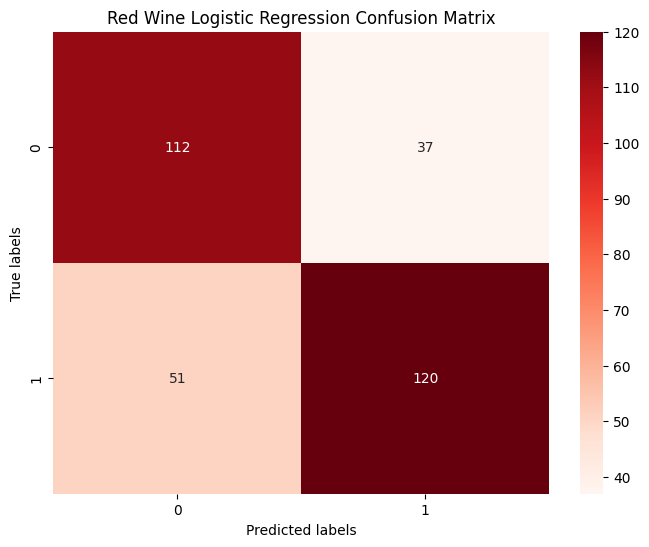

In [106]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix2, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Red Wine Logistic Regression Confusion Matrix')
plt.show()

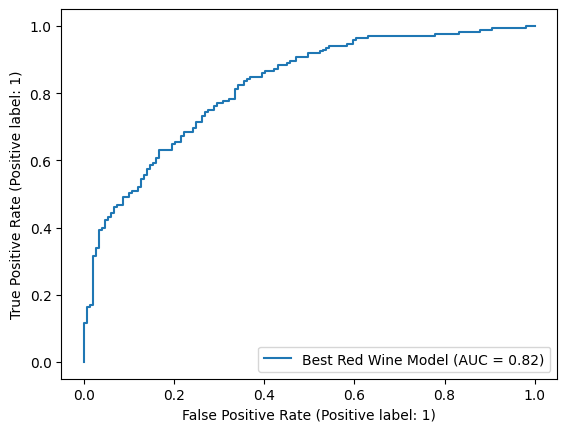

In [69]:
RocCurveDisplay.from_estimator(best_model , red_x_test, red_y_test, name='Best Red Wine Model')

Red Wine ROC AUC is better (0.82) than Full wine AUC(0.79)

### Results from Red Wine (Good/Bad) LR Machine Learning


Pretty consistent results across the different CrossValidation, Grid Search and Naive methods. Grid Search with 5-fold CV has Test Accuracy~72.5%, with an F1 of 0.73 and G-mean of 0.73 and a corresponding Confusion matrix that supports the correct classificaiton of the wine quality into good/bad.

Definitely better than the full dataset

## White Wine Machine Learning

In [70]:
white_x = white_df2_cat.drop(['quality_cat','quality_num','quality'], axis=1)
white_y = white_df2_cat['quality_num']
white_x.head()
#print(red_y)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9


In [71]:
white_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         4898 non-null   float64
 1   volatile_acidity      4898 non-null   float64
 2   citric_acid           4898 non-null   float64
 3   residual_sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free_sulfur_dioxide   4898 non-null   float64
 6   total_sulfur_dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
dtypes: float64(11)
memory usage: 421.0 KB


In [72]:
white_x_train, white_x_test, white_y_train, white_y_test = train_test_split(
    white_x, white_y, test_size=0.2, random_state=7,stratify=white_y)

In [73]:
white_num_variable = white_x.select_dtypes(include=['int64', 'float64']).columns
white_cat_variable = white_x.select_dtypes(include=['object', 'bool']).columns

In [74]:
white_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=7, max_iter=1000))
])

In [75]:
cv = StratifiedKFold(n_splits=5)

In [76]:
param_grid = {
    'classifier__C': np.logspace(-4, 4, 20),
    'classifier__solver': ['lbfgs', 'liblinear']
}

In [77]:
white_grid_search = GridSearchCV(white_pipeline, param_grid, cv=cv, scoring='accuracy')
white_grid_search.fit(white_x_train, white_y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='o...
             param_grid={'classifier__C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'classifier__solver': ['lbfgs', 'liblinear']},
             scoring='accuracy')

In [78]:
white_best_params = white_grid_search.best_params_
white_best_score = white_grid_search.best_score_


white_best_model = white_grid_search.best_estimator_
y_pred_test_white = white_best_model.predict(white_x_test)
y_pred_train_white = white_best_model.predict(white_x_train)
print(white_best_params)
print(white_best_model)

{'classifier__C': 11.288378916846883, 'classifier__solver': 'lbfgs'}
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index([], dtype='object'))])),
                ('classifier',
                 LogisticRegression(C=11.288378916846883, max_iter=1000,
                                    random_state=7))])


In [79]:
white_accuracy_train = accuracy_score(white_y_train, y_pred_train_white)
white_accuracy_test = accuracy_score(white_y_test, y_pred_test_white)
white_error_rate_train = 1 - white_accuracy_train
white_error_rate_test = 1 - white_accuracy_test
f1_score_test_white = f1_score(white_y_test, y_pred_test_white, pos_label=1)  

conf_matrix_white = confusion_matrix(white_y_test, y_pred_test_white)

geo_mean_white = geometric_mean_score(white_y_test, y_pred_test_white)


print(f"Train Accuracy: {white_accuracy_train*100:.2f}%")
print(f"Test Accuracy: {white_accuracy_test*100:.2f}%")
print(f"Train Error Rate: {white_error_rate_train*100:.2f}%")
print(f"Test Error Rate: {white_error_rate_test*100:.2f}%")
print(f"Test F1 Score: {f1_score_test_white:.2f}")
print(f"G-mean:", geo_mean_white) 

print(classification_report(white_y_test, y_pred_test_white))
print(conf_matrix_white)

Train Accuracy: 75.24%
Test Accuracy: 74.80%
Train Error Rate: 24.76%
Test Error Rate: 25.20%
Test F1 Score: 0.82
G-mean: 0.6662207346931114
              precision    recall  f1-score   support

           0       0.66      0.51      0.58       328
           1       0.78      0.87      0.82       652

    accuracy                           0.75       980
   macro avg       0.72      0.69      0.70       980
weighted avg       0.74      0.75      0.74       980

[[168 160]
 [ 87 565]]


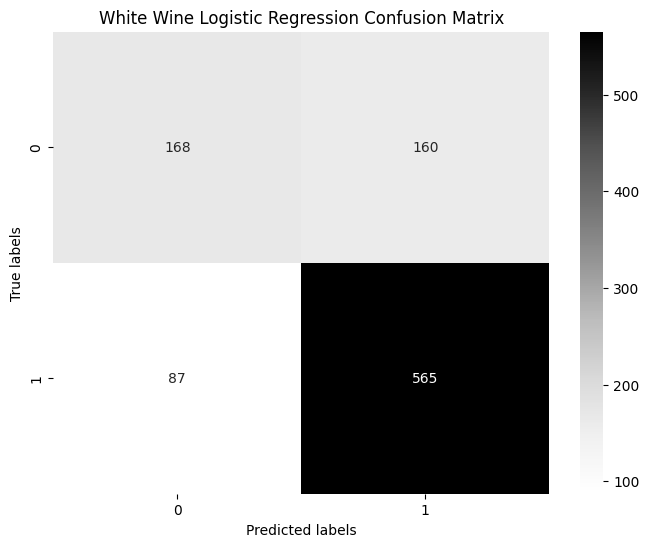

In [107]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_white, annot=True, fmt='d', cmap='Greys')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('White Wine Logistic Regression Confusion Matrix')
plt.show()

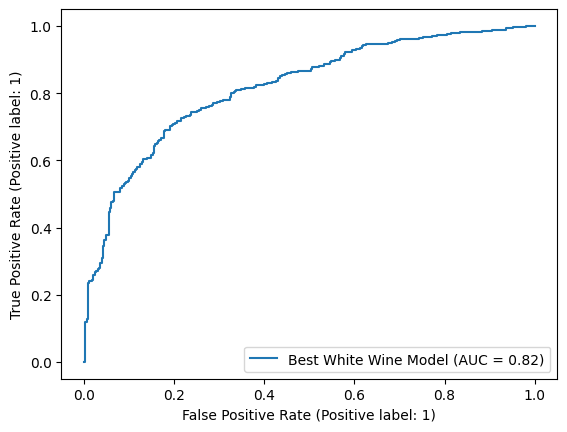

In [81]:
RocCurveDisplay.from_estimator(white_best_model , white_x_test, white_y_test, name='Best White Wine Model')

## White Wine Log Reg ML Summary
Results are a bit more mixed for the White wine ML Summary. the Accuracy is pretty similar to the Full and Red wine, but the Gmean(0.66) is lower than the Red Wine ML Log (0.73), and more similar to Full Dataset(0.66). It could be just that White wine dataset is causing the difficult in the Logistic regresion while the Red Wine is easier to model.

White Wine ROC shows better AUC 0.82 than FullDataSet AUC (0.79)

## Tree Search Model for Red Wine

In [82]:
#from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
#from sklearn.tree import DecisionTreeClassifier
#from imblearn.over_sampling import SMOTE
#from imblearn.under_sampling import RandomUnderSampler
#from imblearn.pipeline import Pipeline as ImbPipeline  

In [83]:
tree_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('oversample', SMOTE(random_state=7)),
    ('undersample', RandomUnderSampler(random_state=7)),
    ('classifier', DecisionTreeClassifier(random_state=7)),
])

In [84]:
tree_param_grid = [
    {
        'classifier': [DecisionTreeClassifier(random_state=42)],
        'classifier__max_depth': [2,3,4,5]
    },
    {
        'classifier': [RandomForestClassifier(random_state=42)],
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [3, 10, 20]
    }
]

In [85]:
tree_grid_search = GridSearchCV(tree_pipeline, tree_param_grid, cv=cv, scoring='f1')  

tree_grid_search.fit(red_x_train, red_y_train)

tree_best_params = tree_grid_search.best_params_
tree_best_score = tree_grid_search.best_score_

tree_best_model = tree_grid_search.best_estimator_
tree_y_pred_test = tree_best_model.predict(red_x_test)
tree_y_pred_train = tree_best_model.predict(red_x_train)

tree_accuracy_train = accuracy_score(red_y_train, tree_y_pred_train)
tree_accuracy_test = accuracy_score(red_y_test, tree_y_pred_test)
tree_error_rate_train = 1 - tree_accuracy_train
tree_error_rate_test = 1 - tree_accuracy_test
tree_f1_score_test = f1_score(red_y_test, tree_y_pred_test)  



tree_conf_matrix = confusion_matrix(red_y_test, tree_y_pred_test)
print(tree_conf_matrix )

print(f"Train Accuracy: {tree_accuracy_train*100:.2f}%")
print(f"Test Accuracy: {tree_accuracy_test*100:.2f}%")
print(f"Train Error Rate: {tree_error_rate_train*100:.2f}%")
print(f"Test Error Rate: {tree_error_rate_test*100:.2f}%")
print(f"Test F1 Score: {tree_f1_score_test:.2f}")

print(classification_report(red_y_test, tree_y_pred_test))

[[123  26]
 [ 32 139]]
Train Accuracy: 100.00%
Test Accuracy: 81.88%
Train Error Rate: 0.00%
Test Error Rate: 18.13%
Test F1 Score: 0.83
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       149
           1       0.84      0.81      0.83       171

    accuracy                           0.82       320
   macro avg       0.82      0.82      0.82       320
weighted avg       0.82      0.82      0.82       320



In [86]:
print(tree_best_params)
print(tree_best_model)
tree_geo_mean = geometric_mean_score(red_y_test, tree_y_pred_test)
print(f"Gmean: {tree_geo_mean}")

{'classifier': RandomForestClassifier(max_depth=20, random_state=42), 'classifier__max_depth': 20, 'classifier__n_estimators': 100}
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index([], dtype='object'))])),
                ('oversample', SMOTE(random_state=7)),
                ('undersample', RandomUnderSampler(random_state=7)),
                ('classifier',
                 RandomForestClassifier(max_depth=20, random_state=42))])
Gmean: 0.8191600549177338


In [87]:
final_model = tree_best_model.named_steps['classifier']
print(final_model)



RandomForestClassifier(max_depth=20, random_state=42)


In [88]:
feature_importances = final_model.feature_importances_
print(feature_importances)

[0.07001782 0.11052421 0.06778308 0.05742823 0.0765225  0.05577836
 0.087664   0.0924773  0.06645885 0.12396845 0.19137721]


In [89]:
feature_names = red_x_train.columns

mdi_importances = pd.Series(
    final_model.feature_importances_, index=feature_names
).sort_values(ascending=True)

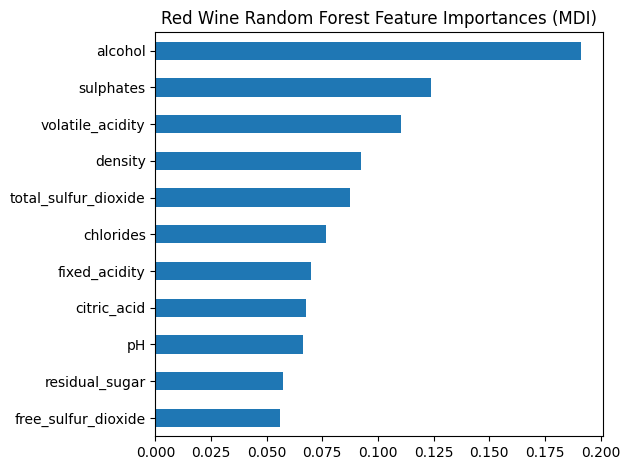

In [90]:
ax = mdi_importances.plot.barh()
ax.set_title("Red Wine Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()

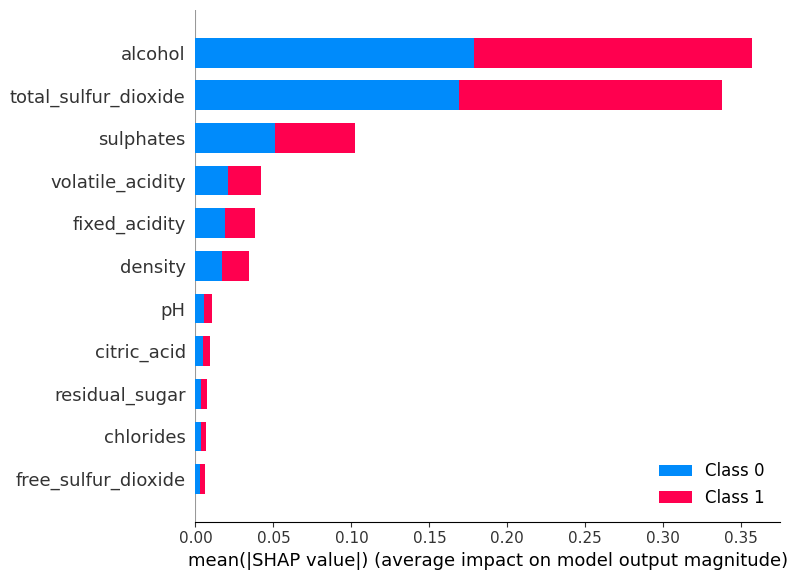

In [91]:
explainer_red = shap.TreeExplainer(final_model)
shap_values_red = explainer_red.shap_values(red_x_test)
shap.summary_plot(shap_values_red, red_x_test)

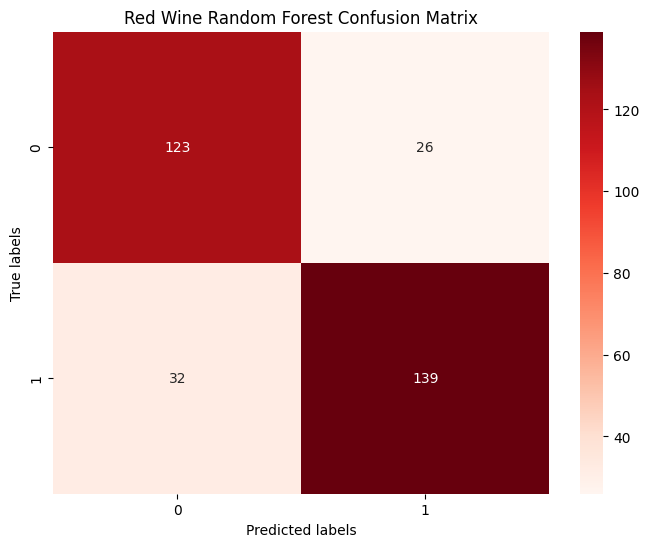

In [108]:
plt.figure(figsize=(8, 6))
sns.heatmap(tree_conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Red Wine Random Forest Confusion Matrix')
plt.show()

# Red Wine Tree Search Conclusion

Did a Grid search and initially included DC, Bagging, and RF. Got good values, with the best result from the grid search ended up being the Bagging model. I found that the Bagging Classifier does not have the built in feature_importance attribute so I narrowed the grid search down to just DC and RF. This ended up with a RF model being the best, with almost identical performance to the inital Bagging classifier. 

This optimized tree search outperformed the Logistic Regression on the confusion matrix, F1 score and Gmean. 

The feature importance investigation revealed that that alcholor, sulphates and volatile acidity were the top 3 predictors. This agrees with the classitical statistics method in terms of significant p-values.

In [93]:
tree_grid_search_white = GridSearchCV(tree_pipeline, tree_param_grid, cv=cv, scoring='f1')  

tree_grid_search_white.fit(white_x_train, white_y_train)

tree_best_params_white = tree_grid_search_white.best_params_
tree_best_score_white = tree_grid_search_white.best_score_

tree_best_model_white = tree_grid_search_white.best_estimator_
tree_y_pred_test_white = tree_best_model_white.predict(white_x_test)
tree_y_pred_train_white = tree_best_model_white.predict(white_x_train)

tree_accuracy_train_white = accuracy_score(white_y_train, tree_y_pred_train_white)
tree_accuracy_test_white = accuracy_score(white_y_test, tree_y_pred_test_white)
tree_error_rate_train_white = 1 - tree_accuracy_train_white
tree_error_rate_test_white = 1 - tree_accuracy_test_white
tree_f1_score_test_white = f1_score(white_y_test, tree_y_pred_test_white)  



tree_conf_matrix_white = confusion_matrix(white_y_test, tree_y_pred_test_white)
print(tree_conf_matrix_white )

print(f"Train Accuracy: {tree_accuracy_train_white*100:.2f}%")
print(f"Test Accuracy: {tree_accuracy_test_white*100:.2f}%")
print(f"Train Error Rate: {tree_error_rate_train_white*100:.2f}%")
print(f"Test Error Rate: {tree_error_rate_test_white*100:.2f}%")
print(f"Test F1 Score: {tree_f1_score_test_white:.2f}")

print(classification_report(white_y_test, tree_y_pred_test_white))

[[258  70]
 [ 85 567]]
Train Accuracy: 100.00%
Test Accuracy: 84.18%
Train Error Rate: 0.00%
Test Error Rate: 15.82%
Test F1 Score: 0.88
              precision    recall  f1-score   support

           0       0.75      0.79      0.77       328
           1       0.89      0.87      0.88       652

    accuracy                           0.84       980
   macro avg       0.82      0.83      0.82       980
weighted avg       0.84      0.84      0.84       980



In [94]:
print(tree_best_params_white)
print(tree_best_model_white)
tree_geo_mean_white = geometric_mean_score(white_y_test, tree_y_pred_test_white)
print(f"Gmean: {tree_geo_mean_white}")

{'classifier': RandomForestClassifier(max_depth=20, random_state=42), 'classifier__max_depth': 20, 'classifier__n_estimators': 100}
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index([], dtype='object'))])),
                ('oversample', SMOTE(random_state=7)),
                ('undersample', RandomUnderSampler(random_state=7)),
                ('classifier',
                 RandomForestClassifier(max_depth=20, random_state=42))])
Gmean: 0.8270669426758728


In [95]:
final_model_white = tree_best_model.named_steps['classifier']
print(final_model_white)

RandomForestClassifier(max_depth=20, random_state=42)


In [96]:
feature_importances_white = final_model_white.feature_importances_
print(feature_importances_white)

[0.07001782 0.11052421 0.06778308 0.05742823 0.0765225  0.05577836
 0.087664   0.0924773  0.06645885 0.12396845 0.19137721]


In [97]:
feature_names_white = white_x_train.columns

mdi_importances_white = pd.Series(
    final_model_white.feature_importances_, index=feature_names_white
).sort_values(ascending=True)

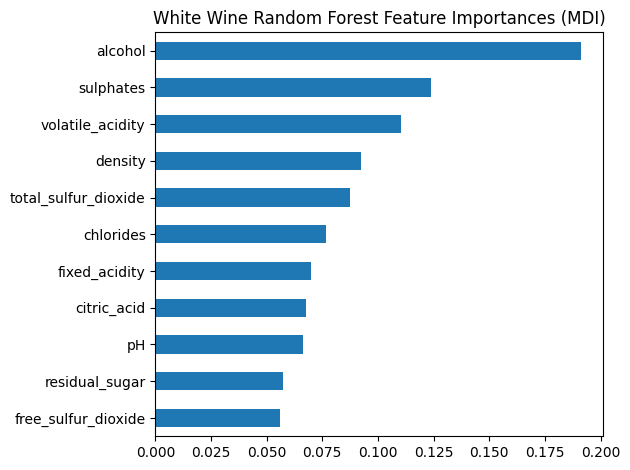

In [98]:
ax = mdi_importances_white.plot.barh()
ax.set_title("White Wine Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()

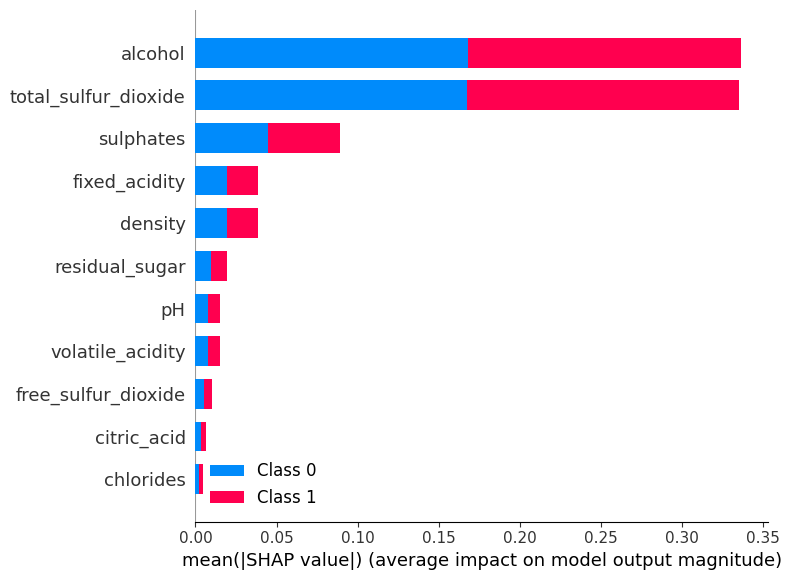

In [99]:
explainer_white = shap.TreeExplainer(final_model_white)
shap_values_white = explainer_white.shap_values(white_x_test)
shap.summary_plot(shap_values_white, white_x_test)

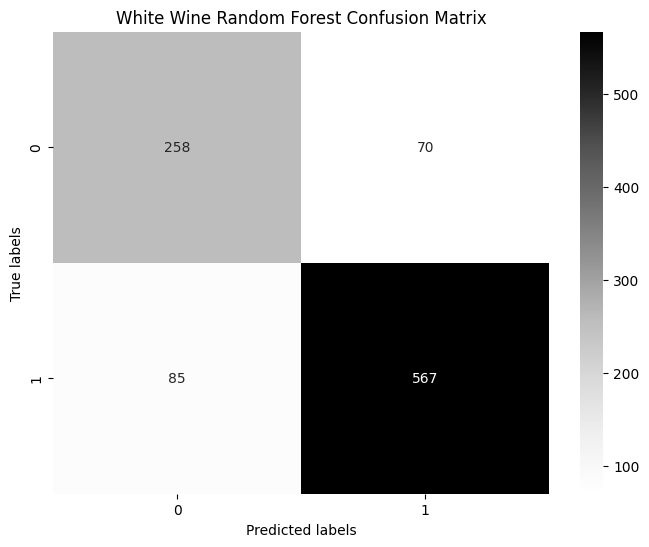

In [109]:
plt.figure(figsize=(8, 6))
sns.heatmap(tree_conf_matrix_white, annot=True, fmt='d', cmap='Greys')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('White Wine Random Forest Confusion Matrix')
plt.show()

## White Tree Model Summary
The white tree model had the best F1 (0.88) and Gmean (0.83) compared to the Full Dataset F1(0.86) and Gmean(0.81). This seems to indicate that there is something specific about each type of wine that is creating a better fit by restricting the data to the limited dataset, even if the effect is not huge.

The Feature importance for white wine 1) Alcohol, 2)Sulphates matched the Red Wine. As did the SHAP top 2 of Alcohol and Total Sulphur Dioxide. It shows that the explainable AI metrics don't always agree on the top most important feastures, but in this case Alcohol seemed to be consistently #1, while the number 2 spot was more variable. For the Full Dataset it was also different with Feasture Importance 1)alcohol, 2) Volatile Acidity and SHAP 1) Alcohol, 2) Fixed Acidity.

